In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
dataset = pd.read_csv('OSM_training_data/ensemble_dataset.csv')

In [3]:
dataset.head()

cat_dict = {0:'ADULT', 1:'COUNTERFEIT', 2:'LEGIT', 3:'PHARMA', 4:'SMOKE', 5:'TMS', 6:'WEAPON'}
dataset['category_number'] = dataset['category_number'].map(cat_dict)

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
import nltk

Using TensorFlow backend.


In [5]:
data = dataset.drop_duplicates(subset='name')
data.head()

,Unnamed: 0,index,id,name,bodytxt,seller_id,tagtxt,price,category_number,risk,combinedtxt_noNumSWPunc_morethan2char,combinedtxt,seller_id_indices
0,0,0,58d3365f3f6f673be6804786,Fat Burners & Thermogenics BLOODSHR3D (WAR EDI...,BLOODSHR3D (WAR EDITION) Ultra Premium Fat Bur...,53665695,NaN,282.84,LEGIT,1,Fat Burners Thermogenics BLOODSHRD WAR EDITION...,Fat Burners & Thermogenics BLOODSHR3D (WAR EDI...,[526]
1,1,1,58d33f023f6f673be68083ee,Vitamins Hylands Cell Salts #12 Silicea 30X Ta...,"Hyland's Cell Salts #12 Silicea 30X Tablets, N...",53665695,NaN,145.88,LEGIT,1,Vitamins Hylands Cell Salts Silicea Tablets Na...,Vitamins Hylands Cell Salts #12 Silicea 30X Ta...,[526]
2,2,2,58d342283f6f673be680a84e,Vitamins Biotics Research - Detoxification 4oz,Biotics Research - Detoxification 4oz Product ...,53665695,NaN,248.77,LEGIT,1,Vitamins Biotics Research Detoxification Bioti...,Vitamins Biotics Research - Detoxification 4oz...,[526]
3,3,3,58d39b683f6f673be680f255,HEWLETT-PACKARD C3903A Toner 4000 Page-Yield B...,HEWLETT-PACKARD C3903A Toner 4000 Page-Yield B...,53889844,NaN,492.20,LEGIT,1,HEWLETT PACKARD Toner Page Yield Black Clear S...,HEWLETT-PACKARD C3903A Toner 4000 Page-Yield B...,[563]
4,4,4,58d4862b3f6f673be6813014,Herbal Supplements Natural Natural Blood Press...,Natural Blood Pressure Supplement: Blood Press...,53665695,NaN,233.52,LEGIT,1,Herbal Supplements Natural Natural Blood Press...,Herbal Supplements Natural Natural Blood Press...,[526]


In [6]:
#features = ['name', 'bodytxt', 'tagtxt', 'price', 'category_number', 'combinedtxt_noNumSWPunc_morethan2char']
features = ['name', "category_number"]
df = data[features]

# these rows contain erraneous values such as ??/??/??//?????////
df = df.drop(df.index[[7724, 23619, 23865]])


df.head()

,name,category_number
0,Fat Burners & Thermogenics BLOODSHR3D (WAR EDI...,LEGIT
1,Vitamins Hylands Cell Salts #12 Silicea 30X Ta...,LEGIT
2,Vitamins Biotics Research - Detoxification 4oz,LEGIT
3,HEWLETT-PACKARD C3903A Toner 4000 Page-Yield B...,LEGIT
4,Herbal Supplements Natural Natural Blood Press...,LEGIT


In [7]:
cat_dict_reverse = {'ADULT':0, 'COUNTERFEIT':1, 'LEGIT':2, 'PHARMA':3, 'SMOKE':4,'TMS':5, 'WEAPON':6}
df['category_number'] = df['category_number'].map(cat_dict_reverse)
df.head()


,name,category_number
0,Fat Burners & Thermogenics BLOODSHR3D (WAR EDI...,2
1,Vitamins Hylands Cell Salts #12 Silicea 30X Ta...,2
2,Vitamins Biotics Research - Detoxification 4oz,2
3,HEWLETT-PACKARD C3903A Toner 4000 Page-Yield B...,2
4,Herbal Supplements Natural Natural Blood Press...,2


In [8]:
docs = df['name'].values
labels = df['category_number'].values


In [9]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)
# convert integers to dummy variables (i.e. one hot encoded)
y = np_utils.to_categorical(encoded_Y)

y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [10]:
docs[0]

'Fat Burners & Thermogenics BLOODSHR3D (WAR EDITION) Ultra Premium Fat Burning & Thermogenic Fuel by Olympus Labs (GRAPE BUBBLEGUM)'

In [11]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

#from nltk.stem import LancasterStemmer
from nltk.stem import PorterStemmer

import re

#lancaster=LancasterStemmer()
porter = PorterStemmer()

for i, d in enumerate(docs):
    
    docs[i].replace("(", " ")
    docs[i].replace(")", " ")
    docs[i].replace("[", " ")
    docs[i].replace("]", " ")
    
    # remove all () including the content in between them 
    # docs[i] = re.sub(r" ?\([^)]+\)", " ",  docs[i])

    # remove all [] including the content in between them 
    # docs[i] = re.sub(r'\[[^()]*\]', " ",  docs[i])

    # remove all non-alphanumeric characters 
    docs[i] = re.sub('[^A-Za-z\s]+', '', docs[i])
    
    a = docs[i].split(" ")
    
    # stopword removal 
    a = [k for k in a if not k in stop_words]
    
    # stemming
    for c, word in enumerate(a):
        a[c] = porter.stem(word)
        
    docs[i] = " ".join(a)


In [12]:
docs[0]

'fat burner  thermogen bloodshrd war edit ultra premium fat burn  thermogen fuel olympu lab grape bubblegum'

In [13]:
d = {} 

from keras.preprocessing.text import Tokenizer,  text_to_word_sequence

for i, val in enumerate(docs):
    k = str(len(text_to_word_sequence(val)))
    
    if k == '1':
        print(i, val)
        print(df['name'].iloc[i])
        print("\n\n")
    
    
    if k not in d:
        d[k] = 0 
    
    d[k] += 1     
    
    
# key = number of words in the sentence 
# value = number of occurences which has that number of words in the sentence 

sorted(d.items(), key = lambda x: int(x[0]))

8374 crown
crown



8385 buygetfrwbreesuperdoozwbrdragonswbrmensdelaysprwbraylastlongswbrtamina
buygetfrwbreesuperdoozwbrdragonswbrmensdelaysprwbraylastlongswbrtamina



8488 stud 
stud 



8491 vimaxx
vimaxx



8495 isofe 
isofe 



8748 caralluma 
caralluma 



8846 maxburn
maxburn



10795 LV
LV



23485 collagenday
collagenday



23563 faak                     
faak                     



23617 faak                     
faak                     



23694                   sexo   
                  sexo   



23996 hawthorn
hawthorn



24061 brainbodi
brainbodi



25050 alpha
alpha



25288 marshmallow 
marshmallow 



25705 wisdom
wisdom



26377 tribulu
tribulu



26761 momento
momento



27640 teeth
teeth



27715 postsurgeri
postsurgeri



27969 allerpluscapsulesbyprogena
allerpluscapsulesbyprogena



28827 scar
scar



29041 glovesexamvinypfmdwh
glovesexamvinypfmdwh



29054 glovesexamvinypfsmwh
glovesexamvinypfsmwh



29114 burn
burn



29149 amk
amk



30774 S
S



31987 thi

[('1', 39),
 ('2', 154),
 ('3', 542),
 ('4', 1669),
 ('5', 3847),
 ('6', 5975),
 ('7', 6731),
 ('8', 6174),
 ('9', 5126),
 ('10', 4046),
 ('11', 3195),
 ('12', 2650),
 ('13', 2227),
 ('14', 2008),
 ('15', 1664),
 ('16', 1470),
 ('17', 1242),
 ('18', 1225),
 ('19', 992),
 ('20', 781),
 ('21', 575),
 ('22', 545),
 ('23', 523),
 ('24', 512),
 ('25', 442),
 ('26', 352),
 ('27', 246),
 ('28', 172),
 ('29', 130),
 ('30', 90),
 ('31', 40),
 ('32', 39),
 ('33', 11),
 ('34', 12),
 ('35', 5),
 ('36', 3),
 ('37', 6),
 ('38', 1),
 ('39', 3),
 ('40', 4),
 ('42', 1),
 ('43', 2)]

In [14]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
# pad documents to a max length of 250 words 
max_length = 40
# using Keras's built in pad_sequences 
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')


In [15]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [16]:
embedding_matrix = np.zeros((vocab_size, 100))

absent_words = 0

for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(t.word_index)), '% of total words')

Total absent words are 18722 which is 63.71 % of total words


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_docs, y, test_size = 0.2, random_state = 0, stratify = y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((44376, 40), (11095, 40), (44376, 7), (11095, 7))

## pip install keras-self-attention

Dcoumentation:

https://pypi.org/project/keras-self-attention/


In [17]:
from keras.layers import LSTM, Activation, Dropout, Dense, Input, Bidirectional
from keras_self_attention import SeqSelfAttention

model = Sequential()
word_dim = 100 
e = Embedding(vocab_size, word_dim, weights=[embedding_matrix], input_length=40, trainable=False)
model.add(e)
model.add(Bidirectional(LSTM(764, return_sequences = True)))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(Flatten())

model.add(Dense(len(y[0]), activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 100)           2938600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 1528)          5286880   
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, 40, 1528)          97857     
_________________________________________________________________
flatten_1 (Flatten)          (None, 61120)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 427847    
Total params: 8,751,184
Trainable params: 5,812,584
Non-trainable params: 2,938,600
_________________________________________________________________


In [18]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', patience = 5, verbose=1)

In [20]:
hist = model.fit(X_train, y_train, validation_data =(X_test, y_test), epochs=50, verbose=1, callbacks = [es])


Train on 44376 samples, validate on 11095 samples
Epoch 1/50
44376/44376 [==============================] - 129s 3ms/step - loss: 0.2640 - acc: 0.9117 - val_loss: 0.2371 - val_acc: 0.9274
Epoch 2/50
44376/44376 [==============================] - 127s 3ms/step - loss: 0.1672 - acc: 0.9449 - val_loss: 0.1802 - val_acc: 0.9418
Epoch 3/50
44376/44376 [==============================] - 127s 3ms/step - loss: 0.1300 - acc: 0.9558 - val_loss: 0.1664 - val_acc: 0.9467
Epoch 4/50
44376/44376 [==============================] - 127s 3ms/step - loss: 0.1039 - acc: 0.9641 - val_loss: 0.1700 - val_acc: 0.9481
Epoch 5/50
44376/44376 [==============================] - 127s 3ms/step - loss: 0.0778 - acc: 0.9728 - val_loss: 0.1586 - val_acc: 0.9526
Epoch 6/50
44376/44376 [==============================] - 126s 3ms/step - loss: 0.0564 - acc: 0.9805 - val_loss: 0.1851 - val_acc: 0.9574
Epoch 7/50
44376/44376 [==============================] - 127s 3ms/step - loss: 0.0494 - acc: 0.9838 - val_loss: 0.2091 - 

In [21]:
from sklearn.metrics import f1_score, classification_report

y_pred = model.predict_classes(X_test)
# y_pred = model.predict(X_test)
y_test_int =np.argmax(y_test, axis=1)

f1_score(y_test_int, y_pred, average = 'micro')

0.9498873366381253

In [22]:
target_name = ['ADULT', 'COUNTERFEIT', 'LEGIT', 'PHARMA', 'SMOKE', 'TMS', 'WEAPON']
print(classification_report(y_test_int, y_pred, target_names=target_name))

              precision    recall  f1-score   support

       ADULT       0.83      0.86      0.84       126
 COUNTERFEIT       0.93      0.93      0.93       296
       LEGIT       0.98      0.96      0.97      8718
      PHARMA       0.84      0.90      0.87      1712
       SMOKE       1.00      0.98      0.99        47
         TMS       0.92      0.96      0.94        23
      WEAPON       0.97      0.98      0.98       173

    accuracy                           0.95     11095
   macro avg       0.92      0.94      0.93     11095
weighted avg       0.95      0.95      0.95     11095



In [ ]:
model.save('glove_50_biLSTM_MLP_renew.h5')

In [ ]:
y_pred = model.predict_classes(X_test)
# y_pred = model.predict(X_test)
y_test_int =np.argmax(y_test, axis=1)

In [ ]:
target_name = ['ADULT', 'COUNTERFEIT', 'LEGIT', 'PHARMA', 'SMOKE', 'TMS', 'WEAPON']

for err in np.where(y_test_int != y_pred)[0]:
    print("\n\n")
    print("err index: {}".format(err))
    print("ground truth label: {}".format(target_name[y_test_int[err]]))
    print("predicted label: {}".format(target_name[y_pred[err]]))

    print("processed: {}".format(t.sequences_to_texts(X_test[err].reshape(1, -1))))


In [ ]:

test = padded_docs[11015].reshape(1, -1)
test.shape

start = time.time()
y_pred = model.predict_classes(test)
end = time.time()

print("Time taken for 1 prediction: {} seconds".format(round(end - start, 3)))

In [19]:
from keras.models import load_model
from keras_self_attention import SeqSelfAttention

model.load_weights('glove_50_biLSTM_MLP_renew.h5')

# Simulate Production Performance

In [20]:
path = "prod_bert_perform_eval/clean/"
import pandas as pd

import os
df = pd.DataFrame()
for file in os.listdir(path):
    if file.endswith('.csv'):
        temp_df = pd.read_csv(path+'{}'.format(file), index_col=0)
        print(file,temp_df.shape)
        df = df.append(temp_df)
        
# for easy copying and pasting of code 
df['combined_txt'] = df['prod_name_txt']

11street_dec18_fp.csv (34924, 16)
11street_mar_fp.csv (8451, 16)
11street_jan_fp.csv (39470, 16)
11street_apr_fp.csv (6592, 16)
11street_may_fp.csv (6938, 16)
11street_feb_fp.csv (7159, 16)


In [21]:
df_ai = df[df['heu_reason'].isna() & df['alert_category'].notna()]

import yaml
from yaml import Loader

yaml.load(df_ai['result'].values[0], Loader = Loader)

list_of_dict = list(map(lambda x: yaml.load(x, Loader = Loader), df_ai['result'].values))
max_cat_score = list(map(  lambda x: (max(x.items(), key = lambda y: y[1])), list_of_dict ))


max_cat = list(map(lambda x: x[0], max_cat_score))

cat_dict_reverse = {'ADULT':0, 'COUNTERFEIT':1, 'LEGIT':2, 'PHARMA':3, 'SMOKE':4,'TMS':5, 'WEAPON':6}
max_cat_num = list(map(lambda x: cat_dict_reverse[x], max_cat))

encoded_Y = encoder.transform(max_cat_num)
# convert integers to dummy variables (i.e. one hot encoded)
y = np_utils.to_categorical(encoded_Y)

docs = df_ai['combined_txt'].values


for i, d in enumerate(docs):
    
    docs[i].replace("(", " ")
    docs[i].replace(")", " ")
    docs[i].replace("[", " ")
    docs[i].replace("]", " ")
    
    # remove all () including the content in between them 
    # docs[i] = re.sub(r" ?\([^)]+\)", " ",  docs[i])

    # remove all [] including the content in between them 
    # docs[i] = re.sub(r'\[[^()]*\]', " ",  docs[i])

    # remove all non-alphanumeric characters 
    docs[i] = re.sub('[^A-Za-z\s]+', '', docs[i])
    
    a = docs[i].split(" ")
    
    # stopword removal 
    a = [k for k in a if not k in stop_words]
    
    # stemming
    for c, word in enumerate(a):
        a[c] = porter.stem(word)
        
    docs[i] = " ".join(a)


encoded_docs = t.texts_to_sequences(docs)
max_length = 40
# using Keras's built in pad_sequences 
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [22]:
y_pred = model.predict(padded_docs)
label = model.predict_classes(padded_docs)


In [23]:
res = pd.DataFrame(y_pred, columns = ['ADULT' ,'COUNTERFEIT', 'LEGIT', 'PHARMA', 'SMOKE', 'TMS', 'WEAPON'])
res['LEGIT_modified'] = res['LEGIT'].values + res['PHARMA'].values + res['ADULT'].values + res['COUNTERFEIT'].values
res['att_predicted_cat'] = res.idxmax(axis=1)
res['prod_res_cat'] = max_cat


In [24]:
res.head(10)

,ADULT,COUNTERFEIT,LEGIT,PHARMA,SMOKE,TMS,WEAPON,LEGIT_modified,att_predicted_cat,prod_res_cat
0,4.241986e-04,6.763032e-04,0.983016,1.587170e-02,4.944171e-06,3.149539e-09,6.757216e-06,0.999988,LEGIT_modified,WEAPON
1,6.672036e-06,8.504380e-07,0.987089,1.290161e-02,2.201141e-09,1.088378e-10,1.648546e-06,0.999998,LEGIT_modified,WEAPON
2,5.820202e-04,1.015827e-04,0.792756,2.064948e-01,1.387315e-06,1.606762e-06,6.268667e-05,0.999934,LEGIT_modified,SMOKE
3,2.012586e-07,7.162084e-07,0.999980,1.735078e-05,1.859852e-09,3.108730e-10,1.470338e-06,0.999998,LEGIT_modified,SMOKE
4,9.910903e-10,2.220106e-07,0.999999,1.144735e-06,8.861141e-11,8.529465e-15,2.283416e-08,1.000000,LEGIT_modified,SMOKE
5,6.258426e-08,2.057951e-05,0.999979,3.937927e-07,3.839129e-11,1.678360e-14,4.231187e-10,1.000000,LEGIT_modified,WEAPON
6,3.087242e-03,4.758243e-04,0.996125,3.087661e-04,2.649985e-06,7.386213e-09,1.500075e-07,0.999997,LEGIT_modified,SMOKE
7,1.038757e-03,3.522214e-05,0.979473,1.941167e-02,1.326460e-06,8.758649e-08,3.979091e-05,0.999959,LEGIT_modified,SMOKE
8,3.645350e-08,3.122505e-03,0.996876,8.300436e-07,1.585361e-07,4.055963e-11,7.631898e-08,1.000000,LEGIT_modified,SMOKE
9,1.981416e-03,1.144212e-04,0.839671,1.574961e-01,3.269807e-04,1.827548e-07,4.102188e-04,0.999263,LEGIT_modified,SMOKE


In [25]:
df_ai['att_predicted_cat'] = res['att_predicted_cat'].tolist()
df_ai["prod_res_cat"] = res["prod_res_cat"].tolist()

df_ai['is_result_modified'] = df_ai['att_predicted_cat'] == 'LEGIT_modified'
df_ai['att_predicted_cat'] = df_ai['att_predicted_cat'].replace('LEGIT_modified','LEGIT')

/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [26]:
df_ai['att_predicted_cat'].unique()

array(['LEGIT', 'WEAPON', 'TMS'], dtype=object)

In [27]:
df_ai['is_false_positive'].unique()

array([True, False], dtype=object)

In [28]:
df_ai['case_status'].unique()

array(['Closed'], dtype=object)

In [29]:

df_ai.groupby(
    ['prod_res_cat','att_predicted_cat']).agg(
    {
        '_id': 'count',
        'is_false_positive': lambda val: (val == True).sum(),
        #'case_status': lambda val: (val == 'Closed').sum()
        'is_result_modified': lambda val: (val == True).sum(),
    })

is_result_modified  _id  is_false_positive
prod_res_cat att_predicted_cat                                            
SMOKE        LEGIT                             118  119                 96
TMS          LEGIT                             202  202                136
             TMS                                 0   11                  4
WEAPON       LEGIT                              73   74                 52
             WEAPON                              0    2                  1

In [30]:
df_ai['true_class'] = df_ai.apply(lambda row: 
            'LEGIT' if row['prod_res_cat']!='LEGIT' and row['is_false_positive'] == True else 
            row['prod_res_cat'],axis=1
           )

df_ai['is_false_positive_att'] = df_ai['true_class'] != df_ai['att_predicted_cat']
df_ai['created_datetime'] = pd.to_datetime(df_ai['created_datetime'])
df_ai['modified_datetime'] = pd.to_datetime(df_ai['modified_datetime'])
df_ai['sent_datetime'] = pd.to_datetime(df_ai['sent_datetime'])

/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [31]:
df_ai['month'] = df_ai['modified_datetime'].dt.month
df_ai['prod_res_cat'] = df_ai['prod_res_cat'].replace('nan','LEGIT')
df_ai['prod_res_cat'] = df_ai['prod_res_cat'].fillna('LEGIT')
df_ai['month'] = df_ai['month'].replace(6,5)
df_ai['month'].unique()

/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

array([12,  3,  1,  4,  5,  2])

In [32]:
# Distribution of production data
prod_y = {'COUNTERFEIT':[], 'LEGIT':[], 'ADULT': [], 'PHARMA':[], 'SMOKE':[], 'WEAPON':[], 'TMS':[]}
att_y = {'COUNTERFEIT':[], 'LEGIT':[], 'ADULT': [], 'PHARMA':[], 'SMOKE':[], 'WEAPON':[], 'TMS':[]}

is_fp_prod = {'COUNTERFEIT':[], 'LEGIT':[], 'ADULT': [],'PHARMA':[], 
              'SMOKE':[], 'WEAPON':[], 'TMS':[]}#{'SMOKE':0, 'WEAPON':0, 'TMS':0}
is_fp_att = {'COUNTERFEIT':[], 'LEGIT':[], 'ADULT': [], 'PHARMA':[],
              'SMOKE':[], 'WEAPON':[], 'TMS':[]}
is_res_mod = []

for month in [12,1,2,3,4,5]:

    temp_df = df_ai[df_ai['month'] == month]
    agg_df_prod = temp_df.groupby(
        ['alert_category']).agg(
            {'_id':'count',
            'is_false_positive':lambda val: (val == True).sum()}
        )
        
    agg_df_att = temp_df.groupby(
        ['att_predicted_cat']).agg(
            {'_id':'count',
            'is_false_positive_att':lambda val: (val == True).sum(),
            'is_result_modified':lambda val: (val == True).sum()
            }
        )
    for cat in prod_y.keys():
        try:
            prod_y[cat].append(agg_df_prod['_id'][cat])
            is_fp_prod[cat].append(agg_df_prod['is_false_positive'][cat])
        except KeyError:
            prod_y[cat].append(0)
            is_fp_prod[cat].append(0)
            
    for cat in att_y.keys():
        try:
            att_y[cat].append(agg_df_att['_id'][cat])
            is_fp_att[cat].append(agg_df_att['is_false_positive_att'][cat])
        except KeyError:
            att_y[cat].append(0)
            is_fp_att[cat].append(0)
    is_res_mod.append(agg_df_att['is_result_modified']['LEGIT'])  
    


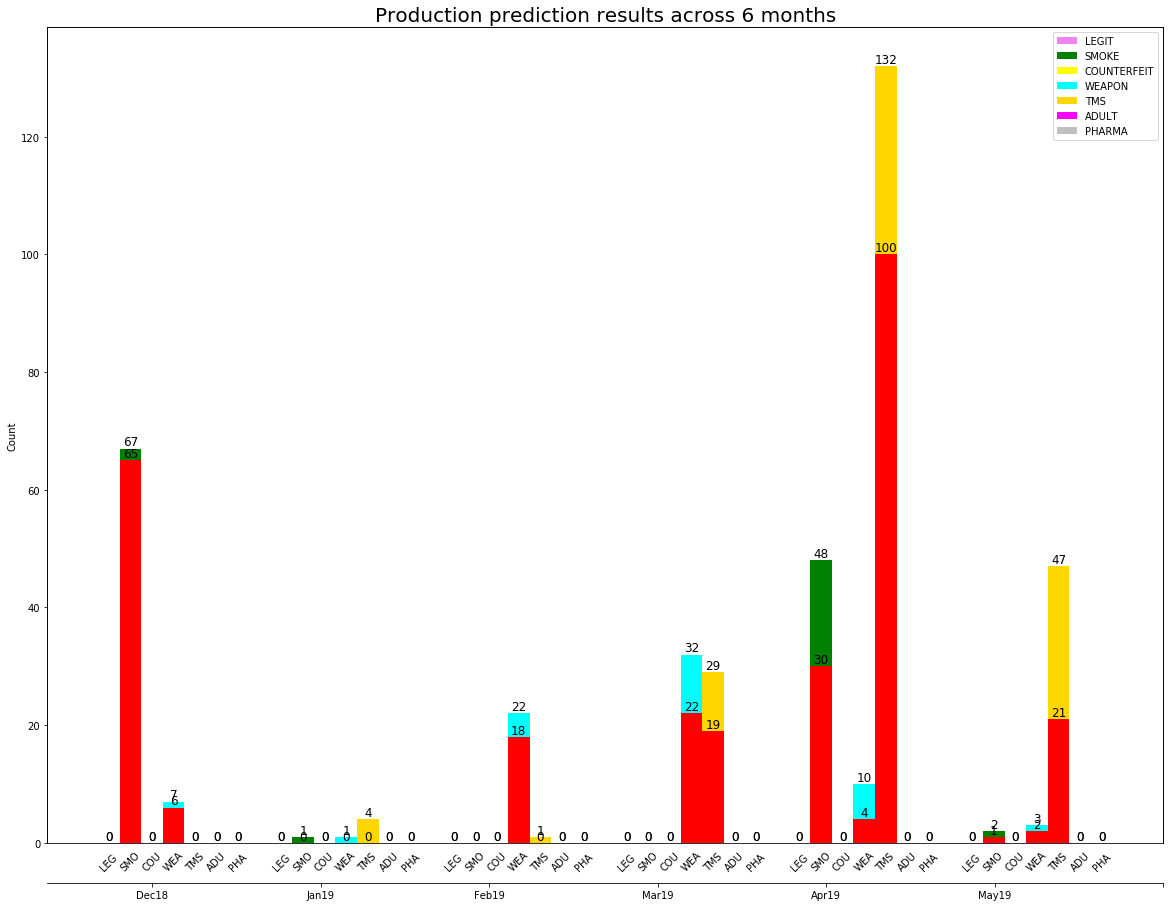

In [33]:
# Clean version

def autolabel(*args):
    
    def autolabel_base(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., h, '%d'%int(h),
                    ha='center', va='bottom', fontsize=12)

    if len(args) > 1:
        rects1 = args[0]
        rects2 = args[1]
        intext = args[2][:3]
        
        for rect,rect2 in zip(rects1, rects2):
            #print('r2', rect2)
            h = rect.get_height()
            h2 = rect2.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., (h+h2), '%d'%int(h+h2),
                    ha='center', va='bottom', fontsize=12)
            ax.text(rect.get_x() + rect.get_width()/2., -5,intext, ha='center', va='bottom', rotation=45)
    else:
        autolabel_base(args[0])
        
import numpy as np
import matplotlib.pyplot as plt

x = ['Dec18', 'Jan19', 'Feb19', 'Mar19', 'Apr19', 'May19']
colors = ["violet", "green", "yellow", "aqua", "gold", "magenta", 'silver']

ind = np.arange(len(x)) # the x locations for the groups
width = 0.125       # the width of the bars

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.set_title('Production prediction results across 6 months',
             fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax.set_ylabel('Count')
ax.set_xticks([])

rects_list = []
for count, key in enumerate(list(prod_y.keys())):
    
    #Plotting count of FPs and for each category across each month
    yfp = is_fp_prod[key]
    yvals = prod_y[key]#[list(prod_y.values())[i][0] for i in range(6)]
    temp_fp = ax.bar(ind + width*count, yfp, width, color='r')
    temp_rects = ax.bar(
        ind + width*count, 
        [yvals[i]-yfp[i] for i in range(len(yvals))],
        width,
        color=colors[count],bottom=yfp)
    
    rects_list.append(temp_rects)
    autolabel(temp_rects, temp_fp, key)
    autolabel(temp_fp)
  

ax.legend( rects_list, att_y.keys())

ax2 = ax.twiny()
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('outward', 40))
#centre_bar_pos = [rec.get_x() for rec in rects_list[3]]
ax2.set_xticks([i+width*5 for i in range(0,7)])
ax2.set_xticklabels( x )
    
plt.show()

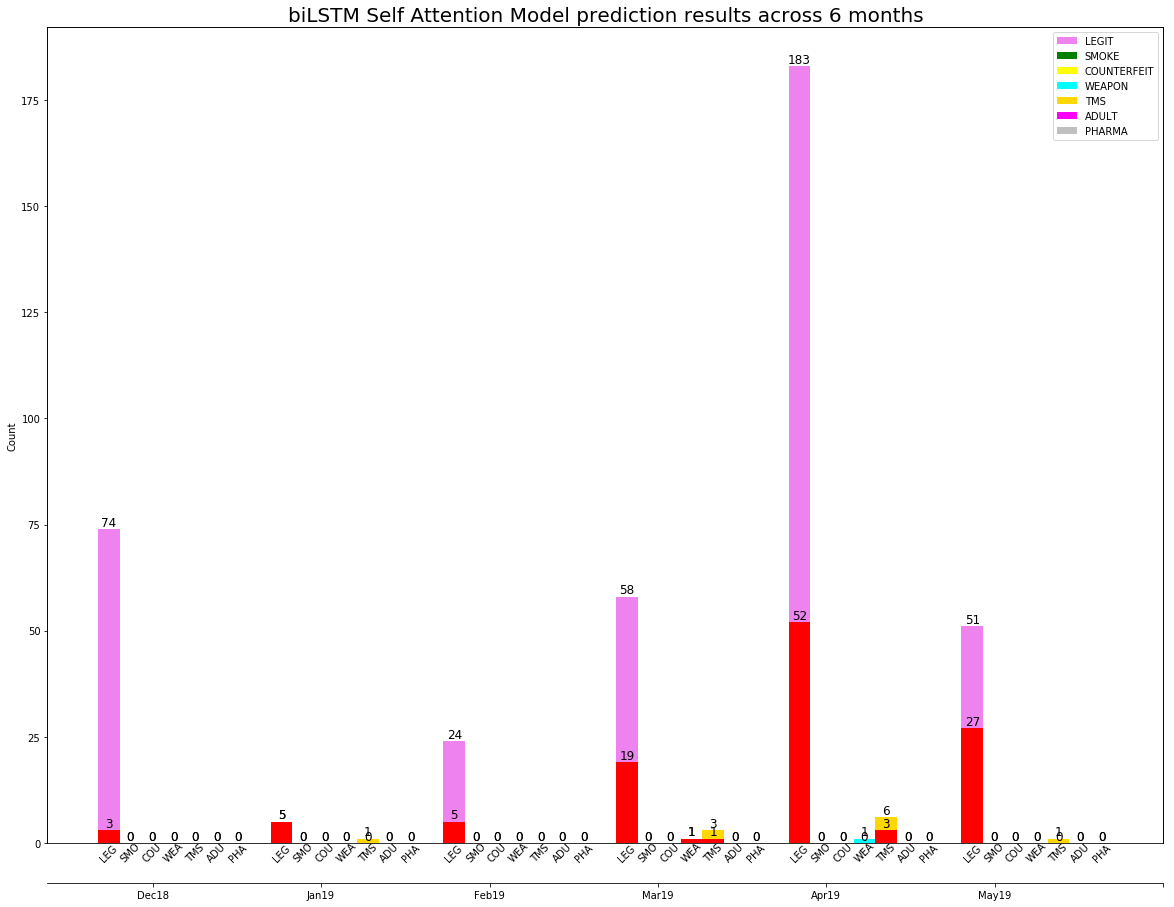

In [34]:
# Clean version

def autolabel(*args):
    
    def autolabel_base(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., h, '%d'%int(h),
                    ha='center', va='bottom', fontsize=12)

    if len(args) > 1:
        rects1 = args[0]
        rects2 = args[1]
        intext = args[2][:3]
        
        for rect,rect2 in zip(rects1, rects2):
            #print('r2', rect2)
            h = rect.get_height()
            h2 = rect2.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., (h+h2), '%d'%int(h+h2),
                    ha='center', va='bottom', fontsize=12)
            ax.text(rect.get_x() + rect.get_width()/2., -5,intext, ha='center', va='bottom', rotation=45)
    else:
        autolabel_base(args[0])
        
import numpy as np
import matplotlib.pyplot as plt

x = ['Dec18', 'Jan19', 'Feb19', 'Mar19', 'Apr19', 'May19']
colors = ["violet", "green", "yellow", "aqua", "gold", "magenta", "silver"]

ind = np.arange(len(x)) # the x locations for the groups
width = 0.125       # the width of the bars

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.set_title('biLSTM Self Attention Model prediction results across 6 months',
             fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax.set_ylabel('Count')
ax.set_xticks([])


rects_list = []
for count, key in enumerate(list(prod_y.keys())):
    #Plotting count of FPs and for each category across each month
    yfp = is_fp_att[key]
    yvals = att_y[key]#[list(prod_y.values())[i][0] for i in range(6)]
    temp_fp = ax.bar(ind + width*count, yfp, width, color='r')
    temp_rects = ax.bar(
        ind + width*count, 
        [yvals[i]-yfp[i] for i in range(len(yvals))],
        width,
        color=colors[count],
        bottom=yfp)

    rects_list.append(temp_rects)
    autolabel(temp_rects, temp_fp, key)
    autolabel(temp_fp)
    
#Plot the modified legit cat

# ax.bar( ind + width, 
#         is_res_mod,
#         width,
#         color='pink')

ax.legend( rects_list, att_y.keys())

ax2 = ax.twiny()
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('outward', 40))
centre_bar_pos = [rec.get_x() for rec in rects_list[0]]
ax2.set_xticks([i+width*5 for i in range(0,7)])#[centre_bar_pos[i]+width for i in range(6)])#ind+width*2)#[ind[i] + centre_bar_pos[i] for i in range(6)])
ax2.set_xticklabels( x )
    
plt.show()

In [35]:
drop_idx =[1641, 1642, 1665, 1674, 1675, 1676, 1677, 5884, 5885, 1620, 8429, 34897, 8412, 1458, 1950, 2827, 3182, 4505, 4507, 4510, 4558, 4581, 5090, 6009, 6015, 6400,6749, 6754, 6757, 6758, 6760, 6762, 6763, 6764, 6765, 6766, 6767, 6769, 6770, 6789]

df_ai = df_ai.drop(drop_idx)

In [36]:
# Distribution of production data
prod_y = {'COUNTERFEIT':[], 'LEGIT':[], 'ADULT': [], 'PHARMA':[], 'SMOKE':[], 'WEAPON':[], 'TMS':[]}
att_y = {'COUNTERFEIT':[], 'LEGIT':[], 'ADULT': [], 'PHARMA':[], 'SMOKE':[], 'WEAPON':[], 'TMS':[]}

is_fp_prod = {'COUNTERFEIT':[], 'LEGIT':[], 'ADULT': [],'PHARMA':[], 
              'SMOKE':[], 'WEAPON':[], 'TMS':[]}#{'SMOKE':0, 'WEAPON':0, 'TMS':0}
is_fp_att = {'COUNTERFEIT':[], 'LEGIT':[], 'ADULT': [], 'PHARMA':[],
              'SMOKE':[], 'WEAPON':[], 'TMS':[]}
is_res_mod = []

for month in [12,1,2,3,4,5]:

    temp_df = df_ai[df_ai['month'] == month]
    agg_df_prod = temp_df.groupby(
        ['alert_category']).agg(
            {'_id':'count',
            'is_false_positive':lambda val: (val == True).sum()}
        )
        
    agg_df_att = temp_df.groupby(
        ['att_predicted_cat']).agg(
            {'_id':'count',
            'is_false_positive_att':lambda val: (val == True).sum(),
            'is_result_modified':lambda val: (val == True).sum()
            }
        )
    for cat in prod_y.keys():
        try:
            prod_y[cat].append(agg_df_prod['_id'][cat])
            is_fp_prod[cat].append(agg_df_prod['is_false_positive'][cat])
        except KeyError:
            prod_y[cat].append(0)
            is_fp_prod[cat].append(0)
            
    for cat in att_y.keys():
        try:
            att_y[cat].append(agg_df_att['_id'][cat])
            is_fp_att[cat].append(agg_df_att['is_false_positive_att'][cat])
        except KeyError:
            att_y[cat].append(0)
            is_fp_att[cat].append(0)
    is_res_mod.append(agg_df_att['is_result_modified']['LEGIT'])  
    


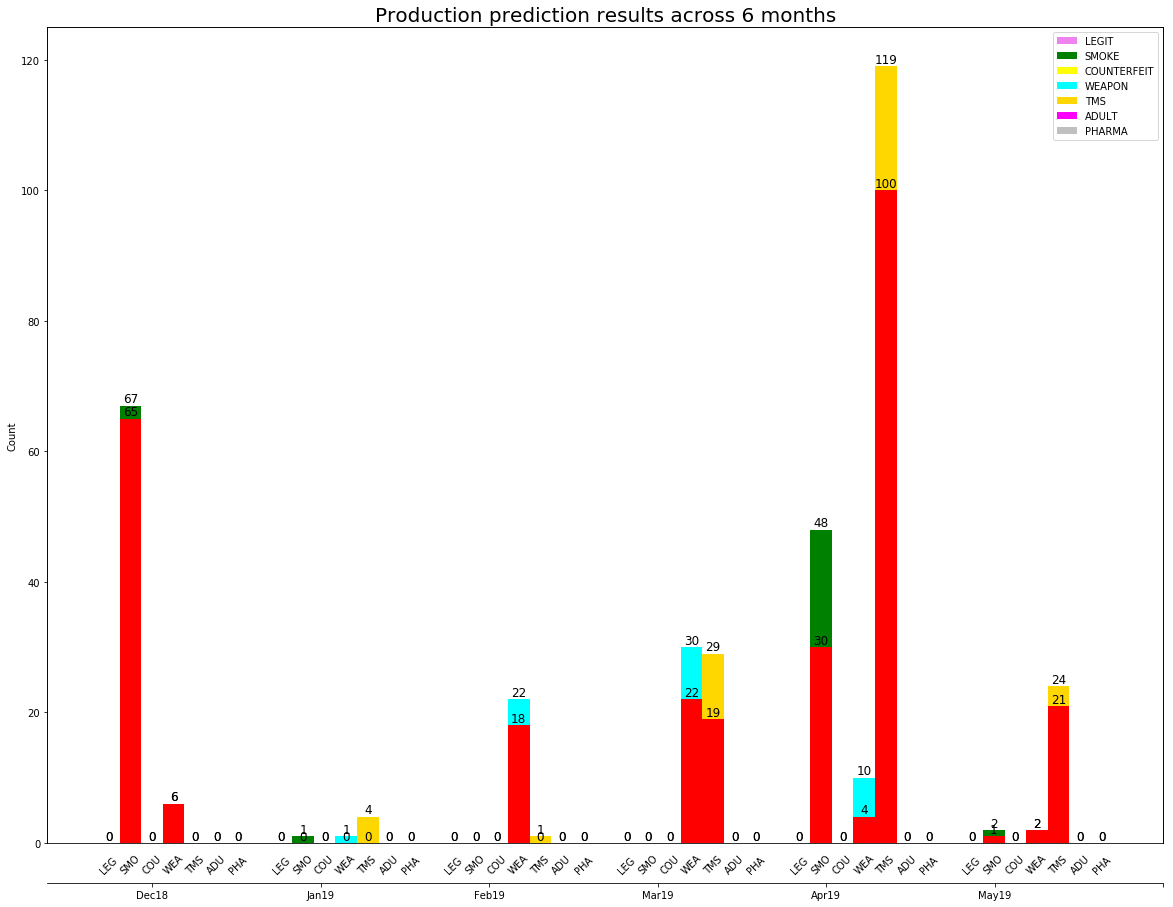

In [37]:
# Clean version

def autolabel(*args):
    
    def autolabel_base(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., h, '%d'%int(h),
                    ha='center', va='bottom', fontsize=12)

    if len(args) > 1:
        rects1 = args[0]
        rects2 = args[1]
        intext = args[2][:3]
        
        for rect,rect2 in zip(rects1, rects2):
            #print('r2', rect2)
            h = rect.get_height()
            h2 = rect2.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., (h+h2), '%d'%int(h+h2),
                    ha='center', va='bottom', fontsize=12)
            ax.text(rect.get_x() + rect.get_width()/2., -5,intext, ha='center', va='bottom', rotation=45)
    else:
        autolabel_base(args[0])
        
import numpy as np
import matplotlib.pyplot as plt

x = ['Dec18', 'Jan19', 'Feb19', 'Mar19', 'Apr19', 'May19']
colors = ["violet", "green", "yellow", "aqua", "gold", "magenta", 'silver']

ind = np.arange(len(x)) # the x locations for the groups
width = 0.125       # the width of the bars

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.set_title('Production prediction results across 6 months',
             fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax.set_ylabel('Count')
ax.set_xticks([])

rects_list = []
for count, key in enumerate(list(prod_y.keys())):
    
    #Plotting count of FPs and for each category across each month
    yfp = is_fp_prod[key]
    yvals = prod_y[key]#[list(prod_y.values())[i][0] for i in range(6)]
    temp_fp = ax.bar(ind + width*count, yfp, width, color='r')
    temp_rects = ax.bar(
        ind + width*count, 
        [yvals[i]-yfp[i] for i in range(len(yvals))],
        width,
        color=colors[count],bottom=yfp)
    
    rects_list.append(temp_rects)
    autolabel(temp_rects, temp_fp, key)
    autolabel(temp_fp)
  

ax.legend( rects_list, att_y.keys())

ax2 = ax.twiny()
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('outward', 40))
#centre_bar_pos = [rec.get_x() for rec in rects_list[3]]
ax2.set_xticks([i+width*5 for i in range(0,7)])
ax2.set_xticklabels( x )
    
plt.show()

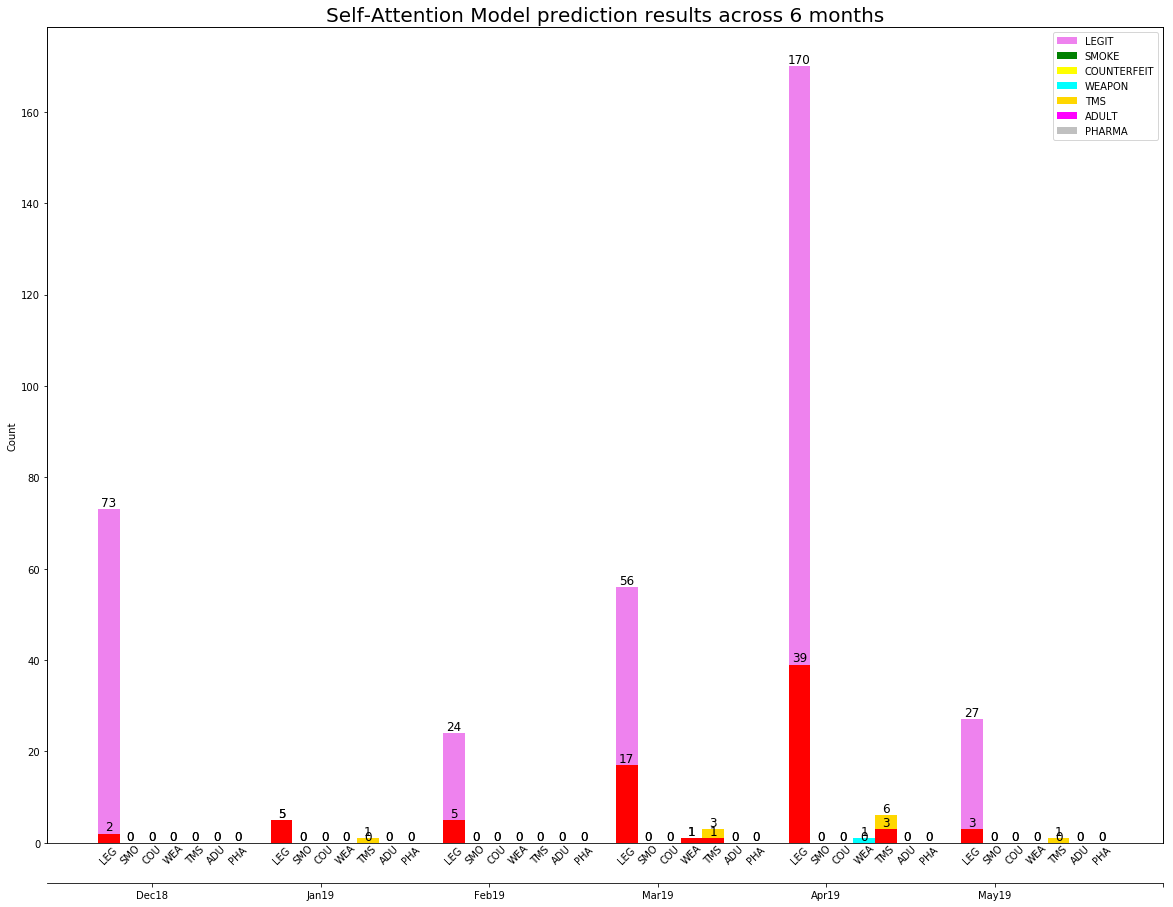

In [40]:
# Clean version

def autolabel(*args):
    
    def autolabel_base(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., h, '%d'%int(h),
                    ha='center', va='bottom', fontsize=12)

    if len(args) > 1:
        rects1 = args[0]
        rects2 = args[1]
        intext = args[2][:3]
        
        for rect,rect2 in zip(rects1, rects2):
            #print('r2', rect2)
            h = rect.get_height()
            h2 = rect2.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., (h+h2), '%d'%int(h+h2),
                    ha='center', va='bottom', fontsize=12)
            ax.text(rect.get_x() + rect.get_width()/2., -5,intext, ha='center', va='bottom', rotation=45)
    else:
        autolabel_base(args[0])
        
import numpy as np
import matplotlib.pyplot as plt

x = ['Dec18', 'Jan19', 'Feb19', 'Mar19', 'Apr19', 'May19']
colors = ["violet", "green", "yellow", "aqua", "gold", "magenta", "silver"]

ind = np.arange(len(x)) # the x locations for the groups
width = 0.125       # the width of the bars

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.set_title('Self-Attention Model prediction results across 6 months',
             fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax.set_ylabel('Count')
ax.set_xticks([])


rects_list = []
for count, key in enumerate(list(prod_y.keys())):
    #Plotting count of FPs and for each category across each month
    yfp = is_fp_att[key]
    yvals = att_y[key]#[list(prod_y.values())[i][0] for i in range(6)]
    temp_fp = ax.bar(ind + width*count, yfp, width, color='r')
    temp_rects = ax.bar(
        ind + width*count, 
        [yvals[i]-yfp[i] for i in range(len(yvals))],
        width,
        color=colors[count],
        bottom=yfp)

    rects_list.append(temp_rects)
    autolabel(temp_rects, temp_fp, key)
    autolabel(temp_fp)
    
#Plot the modified legit cat

# ax.bar( ind + width, 
#         is_res_mod,
#         width,
#         color='pink')

ax.legend( rects_list, att_y.keys())

ax2 = ax.twiny()
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('outward', 40))
centre_bar_pos = [rec.get_x() for rec in rects_list[0]]
ax2.set_xticks([i+width*5 for i in range(0,7)])#[centre_bar_pos[i]+width for i in range(6)])#ind+width*2)#[ind[i] + centre_bar_pos[i] for i in range(6)])
ax2.set_xticklabels( x )
    
plt.show()

In [39]:
a = np.sum(list(is_fp_att.values()))
b = np.sum(list(is_fp_prod.values()))

(b-a)/b

0.7361111111111112